# PPCA in TensorFlow Probability - Part 2: Fixing the parameter problem
This is part 2 of the PPCA in TensorFlow Probability. In part 1, we recreated the PPCA from [one of TFP's tutorials](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb). Although this enabled us to find some latent dataset $\bar{z}$ from which we could simulate a simular dataset $\bar{x}$, we noticed that our estimated latent dataset $\bar{z}$ was much different from our original latent dataset. In this notebook we try to solve that problem.

First we import necessary libraries

In [112]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

We create a function of the original $x = Wz$ model as we did before, so that we obtain $z$ again for analysis. Here we specify the model again.

In [113]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=sigma,
      name="x"), reinterpreted_batch_ndims=2)

In [114]:
num_datapoints = 10000
data_dim = 3
latent_dim = 2

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)

We utilize the model to achieve our MAP values (although we specify flat priors, so we could refer to them as ML values).

In [115]:
actual_sigma, actual_w, actual_z, x_train = model_basis.sample()

sigma = tf.Variable(1.0, dtype=tf.float32)
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, w, z: model_basis.log_prob((sigma, w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1500)

We use Tippings & Bishops PPCA method for comparison and plot the reproduced values of the observed dataset $x$

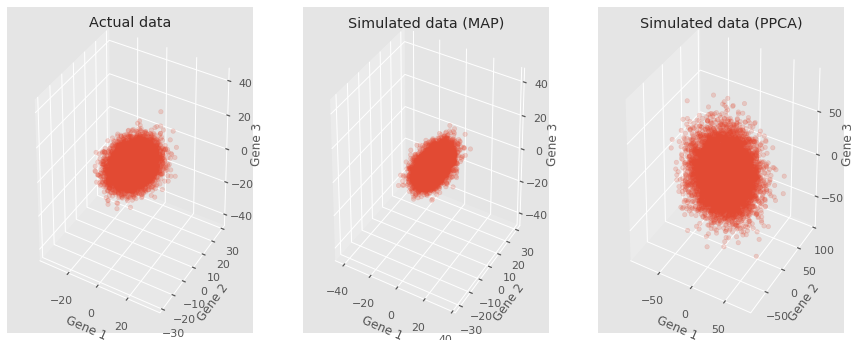

Mean actual data:  [-0.04229285  0.00809229  0.0298848 ] , std.dev:  [10.189438  7.728165 11.552033]
Mean PPCA data:  [-0.41771442  0.27520376  0.09281426] , std.dev:  [20.69387  23.048546 21.589798]
Mean TFP data:  [0.02585351 0.04454747 0.01665446] , std.dev:  [ 9.779333   7.465089  11.3268585]


In [116]:
_, _, _, x_generated = model_basis.sample(value=(sigma, w, z, None))

# Bishops PPCA
ppca = PPCA()
ppca.fit(x_train.numpy().T, mu = np.zeros(data_dim)[np.newaxis].T)
mu_ppca, sigma_ppca, w_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(w_ppca,x_train)[0]
x_ppca = tfd.Normal(loc=tf.matmul(tf.Variable(w_ppca,dtype=tf.float32),tf.Variable(z_ppca,dtype=tf.float32)),scale=tf.Variable(sigma_ppca,dtype=tf.float32),name="x_ppca").sample()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_generated[0,:],x_generated[1,:],x_generated[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_ppca[0,:],x_ppca[1,:],x_ppca[2,:], alpha=0.2)
ax.set_title('Simulated data (PPCA)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

print('Mean actual data: ', np.mean(x_train, axis=1), ', std.dev: ', np.std(x_train, axis=1))
print('Mean PPCA data: ', np.mean(x_ppca, axis=1), ', std.dev: ', np.std(x_ppca, axis=1))
print('Mean TFP data: ', np.mean(x_generated, axis=1), ', std.dev: ', np.std(x_generated, axis=1))

As we can see, our recfreated $\bar{x}$ has approximately the same mean and standard deviation as the original. Our model thus succeeds in finding a latent space and factor loading matrix that recreates the approximate same data.
In the cell below, we see that the found latent dataset $\bar{z}$ is not the same as the original.

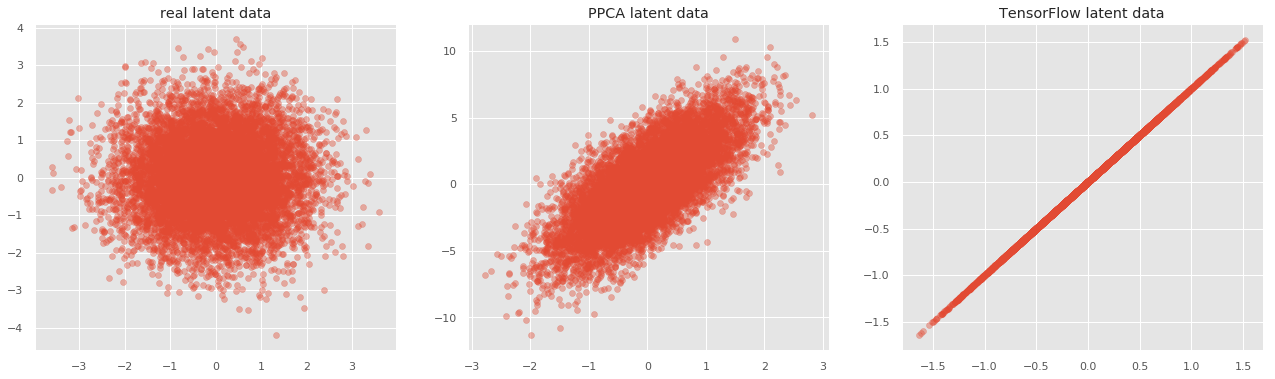

Mean actual latent data:  [-0.00670315  0.00125586] , std.dev:  [0.997183  1.0164775] corr. coeff. axes:  -0.0009987839806658635
Mean PPCA latent data:  [-0.00201702  0.013425  ] , std.dev:  [0.75896997 2.87987901] corr. coeff. axes:  0.724119769470012
Mean TFP latent data:  [-0.00022404 -0.00022404] , std.dev:  [0.4798013 0.4798013] corr. coeff. axes:  0.9999999999999999


In [117]:
z = np.linalg.lstsq(w.numpy(),x_train)[0]

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(actual_z[0,:],actual_z[1,:])[0,1])
print('Mean PPCA latent data: ', np.mean(z_ppca, axis=1), ', std.dev: ', np.std(z_ppca, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z_ppca[0,:],z_ppca[1,:])[0,1])
print('Mean TFP latent data: ', np.mean(z, axis=1), ', std.dev: ', np.std(z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z[0,:],z[1,:])[0,1])

The PPCA creates a latent dataset $z$ that is similar tot he original in terms of mean and standard deviation, but the axes of the latent dataset show a slight correlation as opposed to the original. This suggests that the found dataset is not optimal in terms of dimension reduction and information preservation.

Strangely, the latent dataset as found by TFP shows a perfect correlation of $1.0$! Apart from this, the data is still zero-centered but has smaller standard deviation. This smaller standard deviation in $z$ is probably compensated by a higher $\sigma^2$ of $\bar{x}$ as we see below.

In [118]:
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('simulated variance: ', sigma.numpy()**2)
print()
print('real W:\n', actual_w.numpy())
print('PPCA W:\n', w_ppca)
print('simulated W:\n', w.numpy())
print()

real variance:  19.5810951118076
PPCA variance:  20.049098545392976
simulated variance:  15.138582518805435

real W:
 [[-2.063992  -8.789814 ]
 [ 3.8180332  5.027912 ]
 [-6.5689373 -8.253965 ]]
PPCA W:
 [[  8.8058302   -1.27549719]
 [-12.23399106  -0.8245511 ]
 [  0.42707286   2.67931079]]
simulated W:
 [[ 9.611292   9.611292 ]
 [-6.788845  -6.788845 ]
 [11.4115095 11.4115095]]



Let's take a look at those values of $\bar{z}$ as found by TFP.

In [119]:
print('First latent dimension: ', z[0,:6])
print('Second latent dimension: ', z[1,:6])
print('Are all values equal? ', np.all(z[0,:]==z[1,:]))

First latent dimension:  [-0.51964355  0.9329305  -0.3659181  -0.31614953 -0.05990654  0.05972856]
Second latent dimension:  [-0.51964355  0.9329305  -0.3659181  -0.31614953 -0.05990654  0.05972856]
Are all values equal?  True


As we can see, the values for both dimensions are all exactly equal. If we generate another random sample, this is not the case, so it can not be due to TFP's sampling procedure.

In [120]:
print(tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),scale=tf.ones([latent_dim, num_datapoints])).sample().numpy())

[[ 0.5755912   0.29633114 -0.5470571  ... -0.3986053  -0.95848024
   2.0477138 ]
 [-0.11178491 -0.25957096  0.8952798  ... -0.86174774 -0.2673783
  -0.18803196]]


### First attempt at solving
We will try to solve this by explicitely specifying $\bar{z}$ to have independent axes. Note that $z$ is now specified as a multivariate Gaussian with Identity matrices for covariance matrices.

In [130]:
Root = tfd.JointDistributionCoroutine.Root
cov = [tf.eye(num_datapoints) for i in range(latent_dim)]
def probabilistic_pca_basis_cov(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.MultivariateNormalFullCovariance(loc=tf.zeros([latent_dim, num_datapoints]),
                 covariance_matrix=cov,
                 name="z")))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=sigma,
      name="x"), reinterpreted_batch_ndims=2)

concrete_ppca_model_basis_cov = functools.partial(probabilistic_pca_basis_cov,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_basis_cov = tfd.JointDistributionCoroutine(concrete_ppca_model_basis_cov)

actual_sigma_cov, actual_w_cov, actual_z_cov, x_train_cov = model_basis_cov.sample()

sigma_cov = tf.Variable(1.0, dtype=tf.float32)
w_cov = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_cov = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=500)

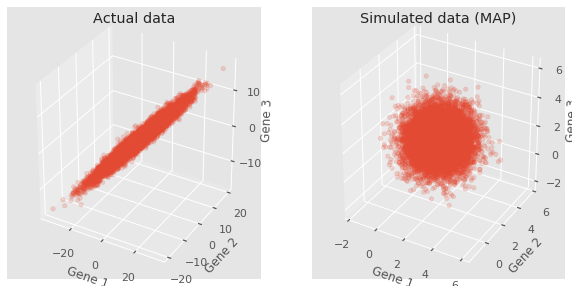

Mean actual data:  [ 0.01230669  0.00632537 -0.00112745] , std.dev:  [8.442049  4.9165893 4.289942 ]
Mean TFP data:  [1.9833504 1.9988244 2.015646 ] , std.dev:  [1.0056889 0.9884665 1.0026122]


In [131]:
_, _, _, x_generated_cov = model_basis.sample(value=(sigma_cov, w_cov, z_cov, None))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x_train_cov[0,:],x_train_cov[1,:],x_train_cov[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_generated_cov[0,:],x_generated_cov[1,:],x_generated_cov[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

print('Mean actual data: ', np.mean(x_train_cov, axis=1), ', std.dev: ', np.std(x_train_cov, axis=1))
print('Mean TFP data: ', np.mean(x_generated_cov, axis=1), ', std.dev: ', np.std(x_generated_cov, axis=1))

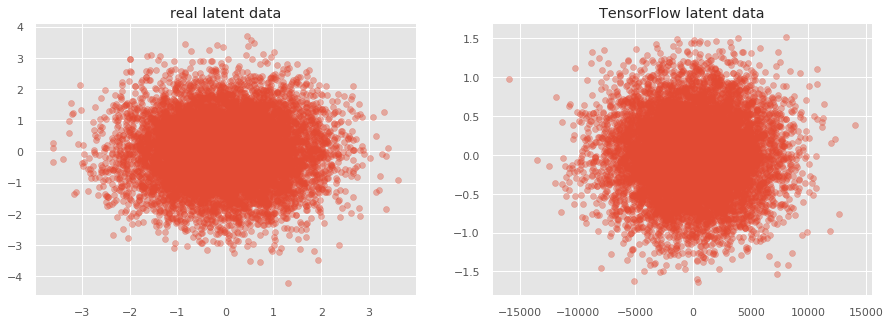

Mean actual latent data:  [-0.00670315  0.00125586] , std.dev:  [0.997183  1.0164775] corr. coeff. axes:  -0.0009987839806658635
Mean TFP latent data:  [-2.3174601e+01 -2.2088832e-04] , std.dev:  [3.5513628e+03 4.7980142e-01] corr. coeff. axes:  -6.752843642900143e-05


In [132]:
z_cov = np.linalg.lstsq(w.numpy(),x_train)[0]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,2,2)
ax.scatter(z_cov[0,:], z_cov[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(actual_z[0,:],actual_z[1,:])[0,1])
print('Mean TFP latent data: ', np.mean(z_cov, axis=1), ', std.dev: ', np.std(z_cov, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z_cov[0,:],z_cov[1,:])[0,1])

Now both $\bar{x}$ and $\bar{z}$ are sometimes very off. The correlation ranges from $0$ to $1$. Unfortunately, we have not succeeded with this try.

### Second attempt at solving
We can also just shuffle one or both of the latent data axes, to reduce the correlation.

In [133]:
np.random.shuffle(z[0,:])
sample_X = tfd.Normal(loc=tf.matmul(tf.Variable(w,dtype=tf.float32),tf.Variable(z,dtype=tf.float32)),scale=sigma,name="x_ppca").sample()

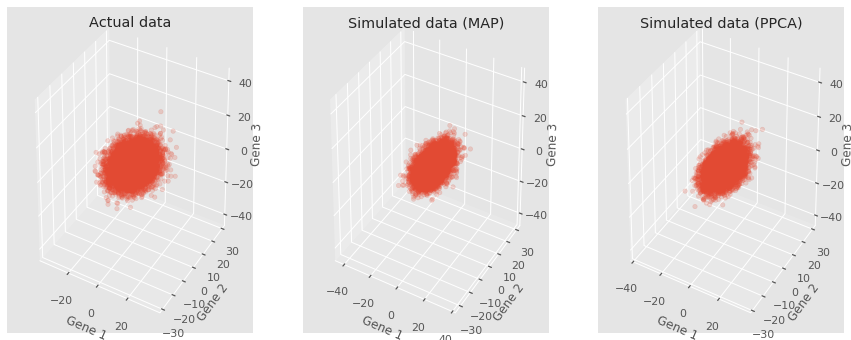

In [134]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_generated[0,:],x_generated[1,:],x_generated[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(sample_X[0,:],sample_X[1,:],sample_X[2,:], alpha=0.2)
ax.set_title('Simulated data (PPCA)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()


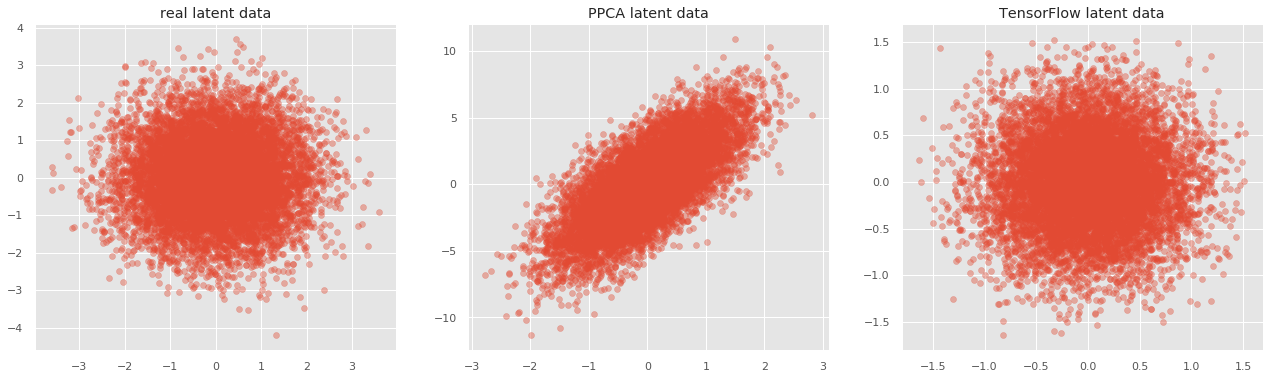

Mean actual latent data:  [-0.00670315  0.00125586] , std.dev:  [0.997183  1.0164775] corr. coeff. axes:  -0.0009987839806658635
Mean PPCA latent data:  [-0.00201702  0.013425  ] , std.dev:  [0.75896997 2.87987901] corr. coeff. axes:  0.724119769470012
Mean TFP latent data:  [-0.00022404 -0.00022404] , std.dev:  [0.4798013 0.4798013] corr. coeff. axes:  0.0020165707775885505


In [135]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(actual_z[0,:],actual_z[1,:])[0,1])
print('Mean PPCA latent data: ', np.mean(z_ppca, axis=1), ', std.dev: ', np.std(z_ppca, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z_ppca[0,:],z_ppca[1,:])[0,1])
print('Mean TFP latent data: ', np.mean(z, axis=1), ', std.dev: ', np.std(z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z[0,:],z[1,:])[0,1])

This works, but its purely aesthetical, we might as well have used one of the unshuffled axes as a one-dimensional latent dataset and it would have been more efficient. This also still does not solve the lower standard deviation.